In [2]:
import imageio
import matplotlib.pyplot as plt
import time
import numpy as np
import pandas as pd
import pickle
from random import randint

In [3]:
from tensorflow import keras
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

Using TensorFlow backend.


In [54]:
import cv2
# Video capture source camera
cap = cv2.VideoCapture(0) 
data_list = []
start_recording = False

while(True):
    ret, frame = cap.read()
    colour = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img = cv2.resize(colour, dsize=(128, 128), interpolation=cv2.INTER_CUBIC)/255
    key_pressed =  str(chr(cv2.waitKey(5) & 0xFF))

    cv2.putText(frame, str(len(data_list)), (10,50), cv2.FONT_HERSHEY_PLAIN, 3, (255,255,255), 2, cv2.LINE_AA)
    cv2.imshow('frame', frame)

    if key_pressed == 'r':
        start_recording = True
    
    if start_recording == True:
        data_list.append(img)
    
    if len(data_list) == 500 or key_pressed == 'e':
        cap.release()
        cv2.destroyAllWindows()
        break

253


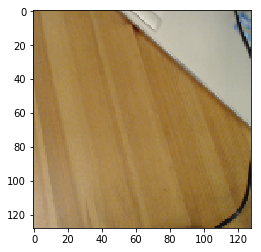

In [55]:
from random import randint
idx = randint(0, len(data_list))
plt.imshow(np.array(data_list[idx]))
print(idx)

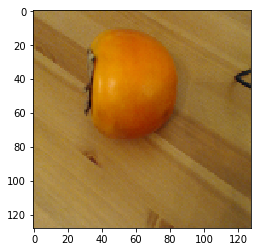

In [38]:
plt.imshow(np.array(data_0[10]))

In [56]:
# Save current capture to disk
current_time = time.strftime("%Y-%m-%d_%H-%M-%S", time.localtime())
with open(f'cam_data_{len(data_list)}_samples_{current_time}', 'wb') as fp:
    pickle.dump(data_list, fp)

In [4]:
from tensorflow import keras
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [5]:
# load the data
with open ('cam_data_500_samples_2018-12-17_19-12-02', 'rb') as fp:
    data_0 = pickle.load(fp)
with open ('cam_data_500_samples_2018-12-17_19-13-02', 'rb') as fp:
    data_1= pickle.load(fp)
with open ('cam_data_500_samples_2018-12-17_19-13-52', 'rb') as fp:
    data_2= pickle.load(fp)
with open ('cam_data_500_samples_2018-12-17_19-37-17', 'rb') as fp:
    data_3= pickle.load(fp)

In [6]:
# Join and split into test/training
X = np.vstack([np.array(data_0), 
               np.array(data_1), 
               np.array(data_2),
               np.array(data_3)])
y = np.hstack([np.zeros(len(data_0)) + 0, 
               np.zeros(len(data_1)) + 1, 
               np.zeros(len(data_2)) + 2,
               np.zeros(len(data_3)) + 3])

# Randomly rotate images
for i in range(X.shape[0]):
    X[i] = np.rot90(X[i], randint(0,3))
    
X_train, X_test, y_train, y_test = train_test_split(X,np.array(pd.get_dummies(y)), test_size=.1)

In [20]:
# Convolutional NN
model = keras.models.Sequential()
n_categories = np.array(pd.get_dummies(y)).shape[1]

layers = [
    keras.layers.Conv2D(32, (3, 3), data_format ="channels_last", padding='same', activation='tanh',input_shape=(128, 128,3)),
    #keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(.25),
 
    keras.layers.Flatten(),
    #keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(.5),
    keras.layers.Dense(n_categories, activation='softmax')
    ]
for layer in layers:
    model.add(layer)

# Compiling the model
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['mae', 'acc'])
model.summary()
history = model.fit(X_train, y_train, epochs=20, batch_size=100, validation_data=(X_test, y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 131072)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 524292    
Total params: 525,188
Trainable params: 525,188
Non-trainable params: 0
_________________________________________________________________
Trai

In [65]:
model.save('trained_classifier_3.h5')

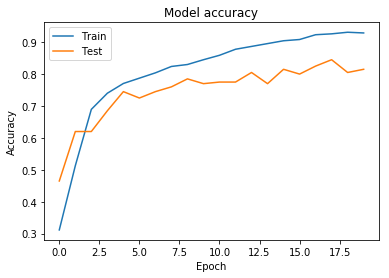

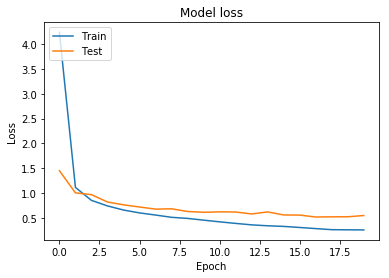

In [21]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

[0 0 1 0] melacaco [[0.71653754 0.01295836 0.26841703 0.00208709]]


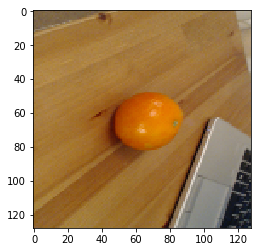

In [17]:
labels = ['melacaco', 'arancia', 'mandarino','vuoto']

idx = randint(0,X_test.shape[0])
plt.imshow(X_test[idx].reshape(128,128,3))
prediction = model.predict(X_test[idx].reshape(1, 128, 128, 3))
print(y_test[idx], labels[np.argmax(prediction)], prediction)

In [8]:
model = keras.models.load_model('trained_classifier_3.h5')

In [22]:
import cv2
cap = cv2.VideoCapture(0) # video capture source camera (Here webcam of laptop) 
labels = ['melacaco', 'arancia', 'mandarino','vuoto']

while(True):
    ret, frame = cap.read()
    colour = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    key_pressed =  str(chr(cv2.waitKey(5) & 0xFF))
    
    img = cv2.resize(colour, dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
    np_img = np.array(img)/255
    prediction = model.predict(np_img.reshape(1, 128, 128, 3))
    prediction_perc = ['{:.1%}'.format(perc) for perc in prediction[0]]
    
    # display the captured image
    cv2.putText(frame, f'{labels[np.argmax(prediction)]} {prediction_perc}', (10,50), cv2.FONT_HERSHEY_PLAIN, 1, (255,255,255), 2, cv2.LINE_AA)
    cv2.imshow('frame', frame)

    if key_pressed == 'e': # close by pressing 'e' 
        cap.release()
        cv2.destroyAllWindows()
        break

array(<tf.Tensor 'conv2d_8/Relu:0' shape=(?, 64, 64, 32) dtype=float32>,
      dtype=object)

[0 0 0 1 0] four [[8.1921723e-07 1.0016714e-07 2.9507143e-04 9.9786502e-01 1.8389821e-03]]


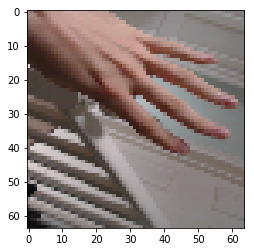

In [145]:
labels = ['melacaco', 'arancia', 'mandarino','vuoto']

idx = randint(0,X_test.shape[0])
plt.imshow(X_test[idx].reshape(64,64,3))
prediction = model.predict(X_test[idx].reshape(1, 64, 64, 3))
print(y_test[idx], labels[np.argmax(prediction)], prediction)

In [ ]:
model.fit(X_train, y_train, epochs=20, batch_size=100, validation_data=(X_test, y_test))